In [24]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [25]:
# Load data
circuits = pd.read_csv('circuits.csv')
races = pd.read_csv('races.csv')
qualifying = pd.read_csv('qualifying.csv')
results = pd.read_csv('results.csv')
drivers = pd.read_csv('drivers.csv')
constructors = pd.read_csv('constructors.csv')


In [26]:
# Merge dataframes
df1 = pd.merge(races, results, how='inner', on='raceId')
df2 = pd.merge(df1, qualifying, how='inner', on=['raceId', 'driverId', 'constructorId'])
df3 = pd.merge(df2, drivers, how='inner', on='driverId')
df4 = pd.merge(df3, constructors, how='inner', on='constructorId')
df5 = pd.merge(df4, circuits, how='inner', on='circuitId')


In [27]:
# Drop NA values and convert date columns
df5.dropna(inplace=True)
df5['date'] = pd.to_datetime(df5['date'])
df5['dob'] = pd.to_datetime(df5['dob'])
df5['age_at_race'] = df5['date'].dt.year - df5['dob'].dt.year
df5 = pd.get_dummies(df5, columns=['nationality_x', 'nationality_y'], drop_first=True)

In [28]:
# Convert 'milliseconds' column to numeric type
df5['milliseconds'] = pd.to_numeric(df5['milliseconds'], errors='coerce')

# Calculate race duration in seconds
df5['race_duration_sec'] = df5['milliseconds'] / 1000

In [29]:
# Group by raceId and driverId to calculate driver and constructor points
driver_points = df5.groupby(['raceId', 'driverId'])['points'].sum().reset_index()
driver_points.rename(columns={'points': 'driver_points'}, inplace=True)
constructor_points = df5.groupby(['raceId', 'constructorId'])['points'].sum().reset_index()
constructor_points.rename(columns={'points': 'constructor_points'}, inplace=True)
df5 = pd.merge(df5, driver_points, on=['raceId', 'driverId'], how='left')
df5 = pd.merge(df5, constructor_points, on=['raceId', 'constructorId'], how='left')

In [30]:
# Add ratio of driver points to constructor points as a new feature
df5['points_ratio'] = df5['driver_points'] / df5['constructor_points']

# Drop unnecessary columns
drop_columns = ['url_x', 'url_y']
df5.drop(columns=drop_columns, inplace=True)

In [31]:
# Define target variable
target_variable = 'position_x'

# Convert 'position_x' column to numeric type
df5['position_x'] = pd.to_numeric(df5['position_x'], errors='coerce')


# Fit ARIMA model
model = ARIMA(df5[target_variable], order=(5, 1, 0))
model_fit = model.fit()

In [32]:
# Print ARIMA model summary
print("ARIMA Model Summary:")
print(model_fit.summary())

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:             position_x   No. Observations:                 8170
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -17724.474
Date:                Tue, 09 Apr 2024   AIC                          35460.948
Time:                        09:34:10   BIC                          35502.997
Sample:                             0   HQIC                         35475.326
                               - 8170                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6036      0.013    -45.735      0.000      -0.629      -0.578
ar.L2         -0.4407      0.015    -28.634      0.000      -0.471      -0.411
ar.L3         -0.2887      0.01

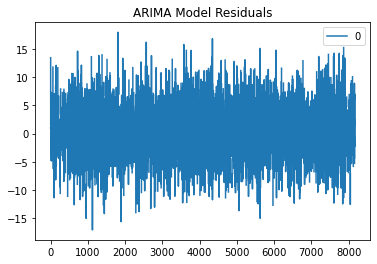

In [33]:
# Plot ARIMA model residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title('ARIMA Model Residuals')
plt.show()

In [36]:
# Drop rows with missing values in both y_true and y_pred
valid_indices = ~np.isnan(y_true) & ~np.isnan(y_pred)
y_true_valid = y_true[valid_indices]
y_pred_valid = y_pred[valid_indices]

# Calculate Mean Absolute Error (MAE) for ARIMA model
mae_arima = mean_absolute_error(y_true_valid, y_pred_valid)
print("ARIMA Model Mean Absolute Error (MAE):", mae_arima)


ARIMA Model Mean Absolute Error (MAE): 3.590293487911667


In [37]:
# Drop non-numeric columns for regression model
X = df5.drop(columns=[target_variable, 'raceId', 'driverId', 'constructorId', 'circuitId', 'resultId'])
y = df5[target_variable]

# Drop rows with missing values
X.dropna(inplace=True)
y = y[X.index]  # Align y with X after dropping rows

In [38]:
# Split the data for regression model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop non-numeric columns from X_train and X_test
non_numeric_cols = X.select_dtypes(exclude=['int', 'float']).columns
X_train = X_train.drop(columns=non_numeric_cols)
X_test = X_test.drop(columns=non_numeric_cols)

In [ ]:
# Train the regression model
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

In [ ]:
# Make predictions using the regression model
regression_predictions = regression_model.predict(X_test)

In [ ]:
# Evaluate the regression model using MAE
regression_mae = mean_absolute_error(y_test, regression_predictions)
print("Regression Model Mean Absolute Error (MAE):", regression_mae)